In [23]:
import torch, torchvision
from matplotlib import pyplot as plt
import numpy as np

In [24]:
class CNN(torch.nn.Module):
  def __init__(self, hidden1_size: int, hidden_size2: int, output_size: int):
    super().__init__()
    
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

    self.flatten = torch.nn.Flatten()

    self.fc1 = torch.nn.Linear(in_features=32*7*7, out_features=hidden1_size)
    self.fc2 = torch.nn.Linear(in_features=hidden1_size, out_features=hidden_size2)
    
    self.ol = torch.nn.Linear(in_features=hidden_size2, out_features=output_size)
  
  def forward(self, input_data):
    max_pooled_conv1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)(torch.nn.functional.relu(self.conv1(input_data)))
    max_pooled_conv2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)(torch.nn.functional.relu(self.conv2(max_pooled_conv1)))

    flattened = self.flatten(max_pooled_conv2)

    fc1_out = torch.nn.functional.relu(self.fc1(flattened))
    fc2_out = torch.nn.functional.relu(self.fc2(fc1_out))

    # outputs = torch.nn.functional.softmax(self.ol(fc2_out))

    return fc2_out
    
    

In [25]:
# # random data
# images = torch.randint(0, 255, (10000, 28, 28), dtype=torch.uint8)
# labels = torch.randint(0, 9, (10000,), dtype=torch.long)
# transformer = torchvision.transforms.Compose([torchvision.transforms.ConvertImageDtype(torch.float32),
#                                              torchvision.transforms.Normalize((0.5,), (0.5,))])
# transformed_data = transformer(images)
# # wraping images and labels
# input_data = torch.utils.data.TensorDataset(transformed_data, labels)


# MINIST data
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Grayscale(num_output_channels=1),
                                              torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])
input_data = torchvision.datasets.MNIST(root="../../.datasets/", train=True, download=True, transform=transformer)


train_data, val_data = torch.utils.data.random_split(input_data, [40000, 20000])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, num_workers=1)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [27]:
model = CNN(hidden1_size=64, hidden_size2=64, output_size=10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
loss_per_epoch = []
loss_per_batch = []
val_accuracy_per_epoch = []
train_batch_count = 0


for epoch in range(epochs):
  train_loss = 0
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    loss_per_batch.append(loss.item())
    train_batch_count += 1
  
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()

  val_acc = correct / len(val_data)
  print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, "
				f"Val Loss={val_loss/len(val_loader):.4f}, Val Acc={val_acc:.4f}")
  
  loss_per_epoch.append(train_loss/len(train_loader))
  val_accuracy_per_epoch.append(val_acc)


Epoch 1: Train Loss=0.6495, Val Loss=0.1021, Val Acc=0.9681
Epoch 2: Train Loss=0.0889, Val Loss=0.0670, Val Acc=0.9787
Epoch 3: Train Loss=0.0631, Val Loss=0.0562, Val Acc=0.9819
Epoch 4: Train Loss=0.0500, Val Loss=0.0492, Val Acc=0.9842
Epoch 5: Train Loss=0.0410, Val Loss=0.0474, Val Acc=0.9854
Epoch 6: Train Loss=0.0338, Val Loss=0.0465, Val Acc=0.9862
Epoch 7: Train Loss=0.0277, Val Loss=0.0462, Val Acc=0.9866
Epoch 8: Train Loss=0.0229, Val Loss=0.0464, Val Acc=0.9869
Epoch 9: Train Loss=0.0188, Val Loss=0.0514, Val Acc=0.9863
Epoch 10: Train Loss=0.0173, Val Loss=0.0554, Val Acc=0.9855


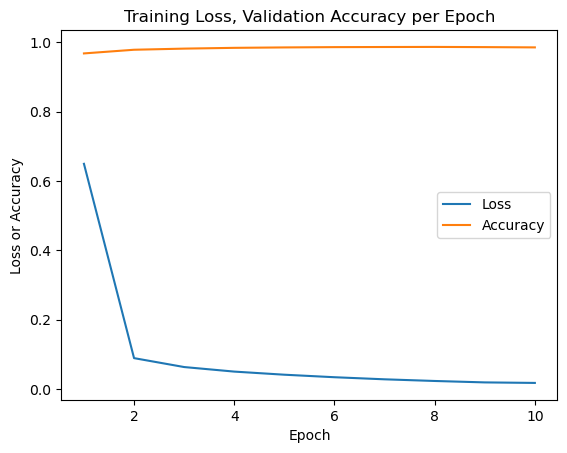

In [30]:
plt.title("Training Loss, Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss or Accuracy")
plt.plot(np.arange(1, epochs+1, 1), loss_per_epoch)
plt.plot(np.arange(1, epochs+1, 1), val_accuracy_per_epoch)
plt.legend(["Loss", "Accuracy"])
plt.show()


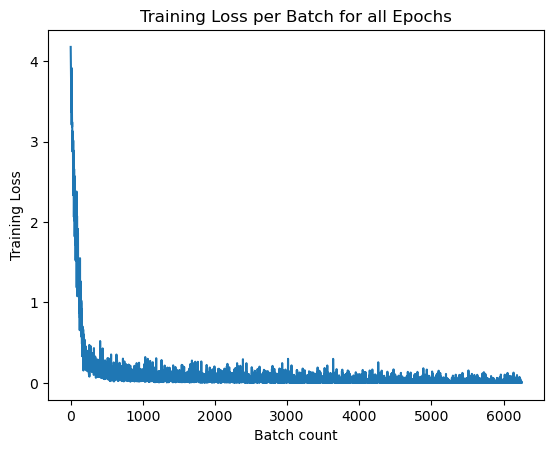

In [31]:
plt.title("Training Loss per Batch for all Epochs")
plt.xlabel("Batch count")
plt.ylabel("Training Loss")
plt.plot(np.arange(1, train_batch_count + 1, 1), loss_per_batch)
plt.show()